In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFE

from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
c = ["#007fff", "#ff3616", "#138d75", "#7d3c98", "#fbea6a"]  # Blue, Red, Green, Purple, Yellow
set2 = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]  # Set2
sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
    },
    font_scale=3.,
    palette=sns.color_palette("Set2")
)
BINS = 256

In [8]:
def truncate_trace(trace, threshold = -7):
    condition = trace < threshold
    counts = np.cumsum(condition)
    idx = np.searchsorted(counts, 3)
    trace = trace[:idx]

    return trace

def clean_data(data, labels):
    data = np.log10(data)
    hists = []
    clean_traces, unfiltered_traces = [], []
    new_labels = []
    for trace, label in zip(data, labels):
        tmp = trace.copy()
        trace = truncate_trace(trace, -6)
        trace = trace[trace < -.5]
        if len(trace) > 10:
            clean_traces.append(trace)
            unfiltered_traces.append(tmp)

            counts, binedges = np.histogram(trace, bins=BINS, range=(-6, -.5))
            hists.append(counts)

            new_labels.append(label)
    
    clean_traces = np.array(clean_traces)
    unfiltered_traces = np.array(unfiltered_traces)
    hists = np.array(hists)
    new_labels = np.array(new_labels)
    return hists, clean_traces, unfiltered_traces, new_labels

def split(x, y, test_size=0.2, random_state=None):
    from sklearn.model_selection import ShuffleSplit
    sss = ShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=random_state
    )

    sss.get_n_splits(x, y)
    train_index, test_index = next(sss.split(x, y))

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    return x_train, x_test, y_train, y_test, train_index, test_index

def low_align(trace):
    low_threshold = np.argmax(trace < -5)
    upper_idx = max(0, low_threshold - 1200)
    lower_idx = min(len(trace), low_threshold + 110)
    xaxis = np.arange(upper_idx, lower_idx)
    trace = trace[upper_idx:lower_idx]
    return xaxis, trace

def create_2d(traces, ax, **kwargs):
    hists = []
    for trace in traces:
        xaxis, trace = low_align(trace)
        H, *_ = np.histogram2d(
            trace,
            np.arange(len(trace)),
            bins=256,
            range=[[-6, .5], [0, len(trace)]]
        )
        hists.append(H)
    hists = np.array(hists)

    im = ax.imshow(
        hists.sum(axis=0),
        extent=[0, len(trace), -6, .5],
        aspect="auto",
        origin="lower",
        cmap="viridis",
        **kwargs,
    )
    return im

def choose_best(labels, threshold):
    labels[labels >= threshold] = 1
    labels[labels < threshold] = 0
    return labels

def create_combined_plot(traces, ax_2d, ax_1d, **kwargs):
    low, high = -6, .5
    hists_2d = []
    hists_1d = []
    for trace in traces:
        _, trace = low_align(trace)
        H, *_ = np.histogram2d(
            trace,
            np.arange(len(trace)),
            bins=256,
            range=[[low, high], [0, len(trace)]]
        )
        hists_2d.append(H)

        counts, binedges = np.histogram(trace, bins=256, range=(low, high))
        hists_1d.append(counts)
    hists_2d = np.array(hists_2d)
    hists_1d = np.array(hists_1d)
    binedges = (binedges[1:] + binedges[:-1])/2

    end = 110
    end *= 0.00065  # nM
    end *= 10  # Ang
    start = -1200
    start *= 0.00065  # nM
    start *= 10  # Ang

    im = ax_2d.imshow(
        hists_2d.sum(axis=0),
        extent=[start, end, low, high],
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmin=0,
        vmax=256,
    )
    ax_1d.plot(hists_1d.sum(axis=0), binedges, **kwargs)
    return im

In [3]:
data = np.load("../andras_bp/all_traces.npy", allow_pickle=True)
labels = np.genfromtxt("../andras_bp/Labels.txt")
data = data[labels != -1]
labels = labels[labels != -1]

hists, clean_traces, unfiltered_traces, labels = clean_data(data, labels)

<ipython-input-2-22ef23420632>:10: RuntimeWarning: invalid value encountered in log10
  data = np.log10(data)
<ipython-input-2-22ef23420632>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clean_traces = np.array(clean_traces)


In [4]:
X = hists
Y = labels
test_size = 0.3

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

### No filtering

In [9]:
train_x, test_x, train_y, test_y, train_indices, test_indices = split(
    X, Y, test_size=test_size, random_state=42,
)

model.fit(train_x, train_y)
y_pred = model.predict(test_x)
print(f"ROC AUC: {metrics.roc_auc_score(test_y, y_pred):.4}")
fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred)
threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Accuracy at best threshold: {metrics.accuracy_score(test_y, choose_best(y_pred, threshold)):.4}")

baseline_perf = [metrics.roc_auc_score(test_y, y_pred), metrics.accuracy_score(test_y, choose_best(y_pred, threshold))]
baseline_features = np.arange(len(X[0]))

ROC AUC: 0.9893
Accuracy at best threshold: 0.9915


## Correct way to filter

In [10]:
def filter_by_criterion(score_func):
    kfilter = SelectKBest(score_func=score_func, k=96)
    train_x, test_x, train_y, test_y, *_ = split(
        X, Y, test_size=test_size, random_state=42,
    )
    train_x_selected = kfilter.fit_transform(train_x, train_y)

    model.fit(train_x_selected, train_y)
    test_x_selected = kfilter.transform(test_x)

    performance = []
    y_pred = model.predict(test_x_selected)
    print(f"ROC AUC: {metrics.roc_auc_score(test_y, y_pred):.4}")
    performance.append(metrics.roc_auc_score(test_y, y_pred))

    fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred)
    threshold = thresholds[np.argmax(tpr - fpr)]
    print(f"Accuracy at best threshold: {metrics.accuracy_score(test_y, choose_best(y_pred, threshold)):.4}")
    performance.append(metrics.accuracy_score(test_y, choose_best(y_pred, threshold)))

    selected_features = kfilter.get_support(indices=True)
    return performance, selected_features

In [11]:
print("F classif")
f_perf, fclassif_features = filter_by_criterion(f_classif)
print("="*25)
print("Chi2")
chi2_perf, chi2_features = filter_by_criterion(chi2)

F classif
ROC AUC: 0.9858
Accuracy at best threshold: 0.9875
Chi2
ROC AUC: 0.9851
Accuracy at best threshold: 0.9862


## Select features and plot them 

In [12]:
rf = RandomForestClassifier()

rfe = RFE(estimator=rf, n_features_to_select=96, step=2)
rfe.fit(train_x, train_y)

rfe_perf = []
y_pred = rfe.predict(test_x)
print(f"ROC AUC: {metrics.roc_auc_score(test_y, y_pred):.4}")
rfe_perf.append(metrics.roc_auc_score(test_y, y_pred))

fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred)
threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Accuracy at best threshold: {metrics.accuracy_score(test_y, choose_best(y_pred, threshold)):.4}")
rfe_perf.append(metrics.accuracy_score(test_y, choose_best(y_pred, threshold)))

rfe_features = rfe.get_support(indices=True)

ROC AUC: 0.9873
Accuracy at best threshold: 0.9895


The labels in the following plot are a bit off. In the main manuscript, we fix the placement of the labels in an image editing software.

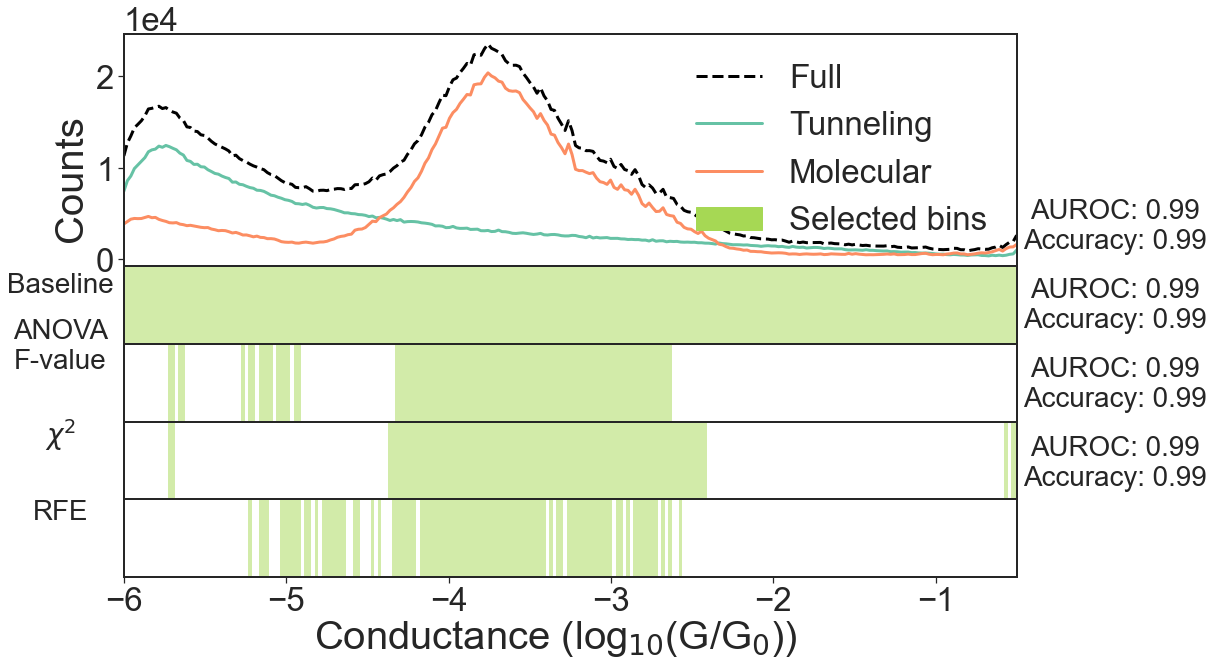

In [14]:
xaxis = np.linspace(-6, -.5, BINS)
fig, axes = plt.subplots(7, 1, figsize=(16, 10), sharey=True, sharex=True)
gs = axes[0].get_gridspec()
for ax in axes[:-4]:
    ax.remove()
axbig = fig.add_subplot(gs[:-4])
axbig.plot(xaxis, X.sum(axis=0), linestyle="--", c="k", label="Full")
axbig.plot(xaxis, X[Y == 0].sum(axis=0), label="Tunneling")
axbig.plot(xaxis, X[Y == 1].sum(axis=0), label="Molecular")

for idx, (ax, features, name, performance) in enumerate(zip(
    axes[-4:],
    [baseline_features, fclassif_features, chi2_features, rfe_features],
    ["Baseline", "ANOVA\nF-value", r"$\chi^2$", "RFE"],
    [baseline_perf, f_perf, chi2_perf, rfe_perf],  # AUROC + accuracy
)):

    perf1 = np.round(performance[0], 2)
    perf2 = np.round(performance[1], 2)
    idx = 4 - idx
    fig.text(.07, 0.1 + idx * .105, name, ha="center", size="x-small")
    fig.text(.985, 0.142 + idx * .11, f"AUROC: {perf1}\nAccuracy: {perf2}", ha="center", size="x-small")
    ax.bar(
        xaxis[features],
        1.1*len(features),
        width=xaxis[1] - xaxis[0],
        linewidth=0,
        alpha=0.5,
        facecolor=set2[4],
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(xaxis[0], xaxis[-1])
    ax.set_yticks([])
fig.text(0.5, 0.04, r"Conductance (log$_{10}$(G/G$_0$))", ha="center", va="center")
fig.text(0.08, 0.68, "Counts", ha="center", va="center", rotation=90)

axbig.ticklabel_format(axis="y", scilimits=(0, 2))
axbig.set_xlim(xaxis[0], xaxis[-1])
axbig.set_xticks([])

plt.subplots_adjust(wspace=0.0, hspace=0)

# Add the overlaid bar plot
handles, labels = axbig.get_legend_handles_labels()
labels.append("Selected bins")
handles.append(plt.Rectangle((0, 0), 1, 1, color=set2[4]))
axbig.legend(handles, labels, frameon=False, loc="upper right")
plt.savefig("filter_features_main.pdf")
plt.show()